![Marvel_Heros](marvel_heros.jpg)

## DataScienceChallenge 2
### _ Marvel Social Graph _

Les héros Marvel et les comics dans lesquels ils apparaissent ont été enrregistrés dans une base de données en graph (Neo4J). Ce type de base de données permet de stocker et requèter efficacement les relations (edges) entre ces éléments (noeuds).

Le langage de programmation est appelé Cypher. Voici un exemple de requète:

```cypher
MATCH (:character)-[relation]->(:comics)
RETURN * LIMIT 1
```



## 1 - Quel comics contiennent le plus de personnages ?

In [2]:
#Connexion à la bdd
from py2neo import Graph, authenticate, Relationship
graph = Graph()
authenticate("localhost:7474","neo4j", "admin")


In [3]:
#Execution de la requète grâce à l'API py2neo
graph.cypher.execute('''
MATCH (c:character)-[r]->(x:comics)
WITH DISTINCT(x.name) AS COMICS, COUNT(r) AS NB_APP
ORDER BY NB_APP DESC 
RETURN COMICS, NB_APP LIMIT 5
''')

   | COMICS               | NB_APP
---+----------------------+--------
 1 | COC 1                |    111
 2 | MARVEL MYSTERY COMIC |     92
 3 | IW 3                 |     91
 4 | IW 1                 |     90
 5 | H2 279               |     87

|      1          |     2        |        3        |        4        |       5         |
|:---------------:|:------------:|:---------------:|:---------------:|:---------------:|
|![coc1](coc1.jpg)|![MARVEL_MYSTERY_COMIC](MARVEL_MYSTERY_COMIC.jpg)|![IW3](IW3.jpg)|![IW1](IW1.jpg)|![H2 279](H2_279.jpg)|

## 2 - Quels personnages apparaissent le plus souvent ?
Plus le personnage est ancien et plus il a de chances d'apparaître dans de nombreux comics.

In [7]:
graph.cypher.execute('''
MATCH (c:character)-[r:APPEARS_IN]->(:comics)
WITH DISTINCT(c.name) AS PERSONNAGE, COUNT(r) AS NB_APP
ORDER BY NB_APP DESC
RETURN PERSONNAGE, NB_APP LIMIT 5
''')

   | PERSONNAGE           | NB_APP
---+----------------------+--------
 1 | SPIDER-MAN/PETER PAR |   1625
 2 | CAPTAIN AMERICA      |   1367
 3 | IRON MAN/TONY STARK, |   1168
 4 | THING/BENJAMIN J. GR |    990
 5 | THOR/DR. DONALD BLAK |    965

| 1  |  2  |  3  |   4  |   5   |
|:---:|:---:|:---:|:---:|:---:|
|![spiderman](spiderman.jpg)|![captain_america](captain_america.jpg)|![ironman](ironman.jpg) |![thing](thing.jpg)|![thor](thor.jpg)|

## 3 - Quels groupes de personnages peut-on identifier ?
Certains personnages, tels que les heros et vilains, apparaissent souvent ensembles. On peut utiliser des algorithmes de clustering pour identifier ces groupes. L'une des difficulté est qu'on ne connait pas à l'avance le nombre de clusters et l'application d'un algorithme classique (K-means) devient difficile.
L'agorithme d'Affinity Propagation permet de prédire des cluster sans connaitre apriori le nombre de cluster.

In [8]:
from py2neo.packages.httpstream import http
http.socket_timeout = 9999   # fix for the socket timeout error

#graph.cypher.execute('''
#    MATCH (m:character)-[r:APPEARS_IN]->(:comics)
#    WITH m, COUNT(DISTINCT r) AS nb_tar
#    SET m.NB_COMICS = nb_tar;
#''')

#calul des distances de Jaccard
#graph.cypher.execute('''
#    MATCH (c1:character)-[r1:APPEARS_IN]->(n:comics)<-[r2:APPEARS_IN]-(c2:character)
#    WITH c1, c2,tofloat(c1.NB_COMICS) AS c1_tar,tofloat(c2.NB_COMICS) AS c2_tar, tofloat(COUNT(DISTINCT n)) AS nb_tar
#    WHERE c1.name <> c2.name
#    WITH c1,c2,(1-nb_tar/(c1_tar + c2_tar - nb_tar)) AS Jaccard
#    CREATE UNIQUE (c1)-[:DISTANCE {JACCARD:Jaccard}]-(c2);
#''')

#extraction des paires et leur distance
pers_paires = graph.cypher.execute('''
    MATCH (c1:character)-[d:DISTANCE]->(c2:character)
    WITH c1,c2,d
    WHERE c1.name <> c2.name
    RETURN c1.name AS PERSONNAGE1, c2.name AS PERSONNAGE2, d.JACCARD AS DISTANCE;
''')

#Creation de la liste de reference des personnages
pers = []
for pair in pers_paires:
    if pair[0] not in pers:
        pers.append(pair[0])
    if pair[1] not in pers:
        pers.append(pair[1])
        
#on stock les personnages dans une dataframe
import pandas as pd
pers_df = pd.DataFrame(pers, columns=["Personnage"])

#creation d'une matrice
import numpy as np
len_mat = len(pers)
mat = np.empty([len_mat,len_mat], dtype=float)
mat.fill(-100.0)

#remplissage de la matrice en suivant l'ordre des personnages de la df
for pair in pers_paires:
    mat[np.where(pers_df.Personnage == pair[0]), np.where(pers_df.Personnage == pair[1])] = -100 * pair[2]
    
#la distance d'un personnage avec lui-meme est 0
np.fill_diagonal(mat,0.0)



In [9]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference = np.median(mat), affinity = "precomputed")
af.fit(mat)

#stockage des labels des clusters pour chaque personnage
pers_df["cluster"] = af.labels_

#combien de clusters?
len(af.cluster_centers_indices_)

1768

In [10]:
#nombre de personnages par clusters
pers_per_cl = []
for i in range(1768):
    nb_pers = len(pers_df.loc[pers_df.cluster == i,:])
    pers_per_cl.append([i,nb_pers])
pers_per_cl

#on rassemble cette info dans une dataframe
cl_df = pd.DataFrame(pers_per_cl,columns=["cluster_nb","nb_pers"])


### Quelle est la taille des clusters ?

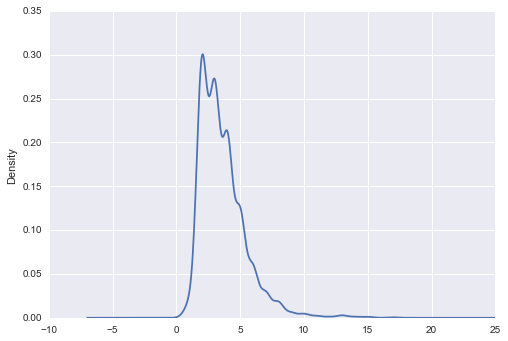

In [11]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

cl_df.nb_pers.plot.density()
plt.show()

## Conclusion

Le réseau social des héros Marvel est un réseau artificiel qui ne peut pas simuler correctement un réseau réel. On observe un grand nombre de clusters de très petite taille.
Une autre mesure de la qualité du clustering (coverage) indique que ce réseau est assès éloigné d'un réseau naturel.

Finalement, les héros Marvel interagissent très peu les uns avec les autres!